## Code Notebook based on tutorial by: https://github.com/drewbyron

In [2]:
%%capture
!pip install pytorch-tutorials==0.2.19
!pip install torch==1.12.1
!pip install torchtext==0.13.1
!pip install torchvision==0.13.1
!pip install pytorch-lightning==1.6.4
!pip install pytorch-lightning-bolts
!pip install torchmetrics==0.9.1
!pip install matplotlib==3.1.3
!pip install numpy==1.21.6
!pip install ipywidgets==7.7.0

## Deep Learning Imports

In [5]:
# Deep learning imports.
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset

import torchvision
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks, make_grid, save_image
from torchvision.ops import masks_to_boxes
import torchvision.transforms.functional as TF
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Standard imports.
from typing import List, Union
import gc
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path

# Necessary for creating our images.
from skimage.draw import line_aa

# Interactive widgets for data viz.
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# pytorch_tutorials imports
from pytorch_tutorials.intro_to_computer_vision import cv_utility
from pytorch_tutorials.intro_to_computer_vision import cv_datasets
from pytorch_tutorials.intro_to_computer_vision import cv_models
from pytorch_tutorials.intro_to_computer_vision import cv_pl_data_modules

# mount google drive (note make sure your drive is actually /drive and not /gdrive)
# from google.colab import drive
# drive.mount('/content/drive')

## apply mask rcnn on a jpeg image

In [6]:
coco_class_map = cv_utility.build_coco_class_map(seed = 12345, drop_background = True)

print(f"Total classes in model: {len(coco_class_map)}\n")

print("First 30 classes: \n")

for i, (key, value) in enumerate(coco_class_map.items()):
    if i >= 30: break
    print(key, ":", value)

Total classes in model: 90

First 30 classes: 

1 : {'name': 'person', 'target_color': (np.int64(205), np.int64(0), np.int64(0))}
2 : {'name': 'bicycle', 'target_color': (np.int64(0), np.int64(129), np.int64(204))}
3 : {'name': 'car', 'target_color': (np.int64(246), np.int64(138), np.int64(0))}
4 : {'name': 'motorcycle', 'target_color': (np.int64(0), np.int64(0), np.int64(0))}
5 : {'name': 'airplane', 'target_color': (np.int64(237), np.int64(208), np.int64(151))}
6 : {'name': 'bus', 'target_color': (np.int64(214), np.int64(134), np.int64(113))}
7 : {'name': 'train', 'target_color': (np.int64(125), np.int64(153), np.int64(0))}
8 : {'name': 'truck', 'target_color': (np.int64(141), np.int64(0), np.int64(0))}
9 : {'name': 'boat', 'target_color': (np.int64(120), np.int64(0), np.int64(193))}
10 : {'name': 'traffic light', 'target_color': (np.int64(232), np.int64(193), np.int64(0))}
11 : {'name': 'fire hydrant', 'target_color': (np.int64(212), np.int64(0), np.int64(244))}
12 : {'name': 'N/A',

## load images in drive onto torc

In [7]:
raw_img_path =r'/content/drive/MyDrive/biotech/Retina_Lab/raw_imgs_maskrcnn'
imgs = cv_utility.load_img_dir(raw_img_path, resize_factor = .5)
for img in imgs:
    print(img.shape)

torch.Size([3, 1512, 2016])
torch.Size([3, 2688, 2016])


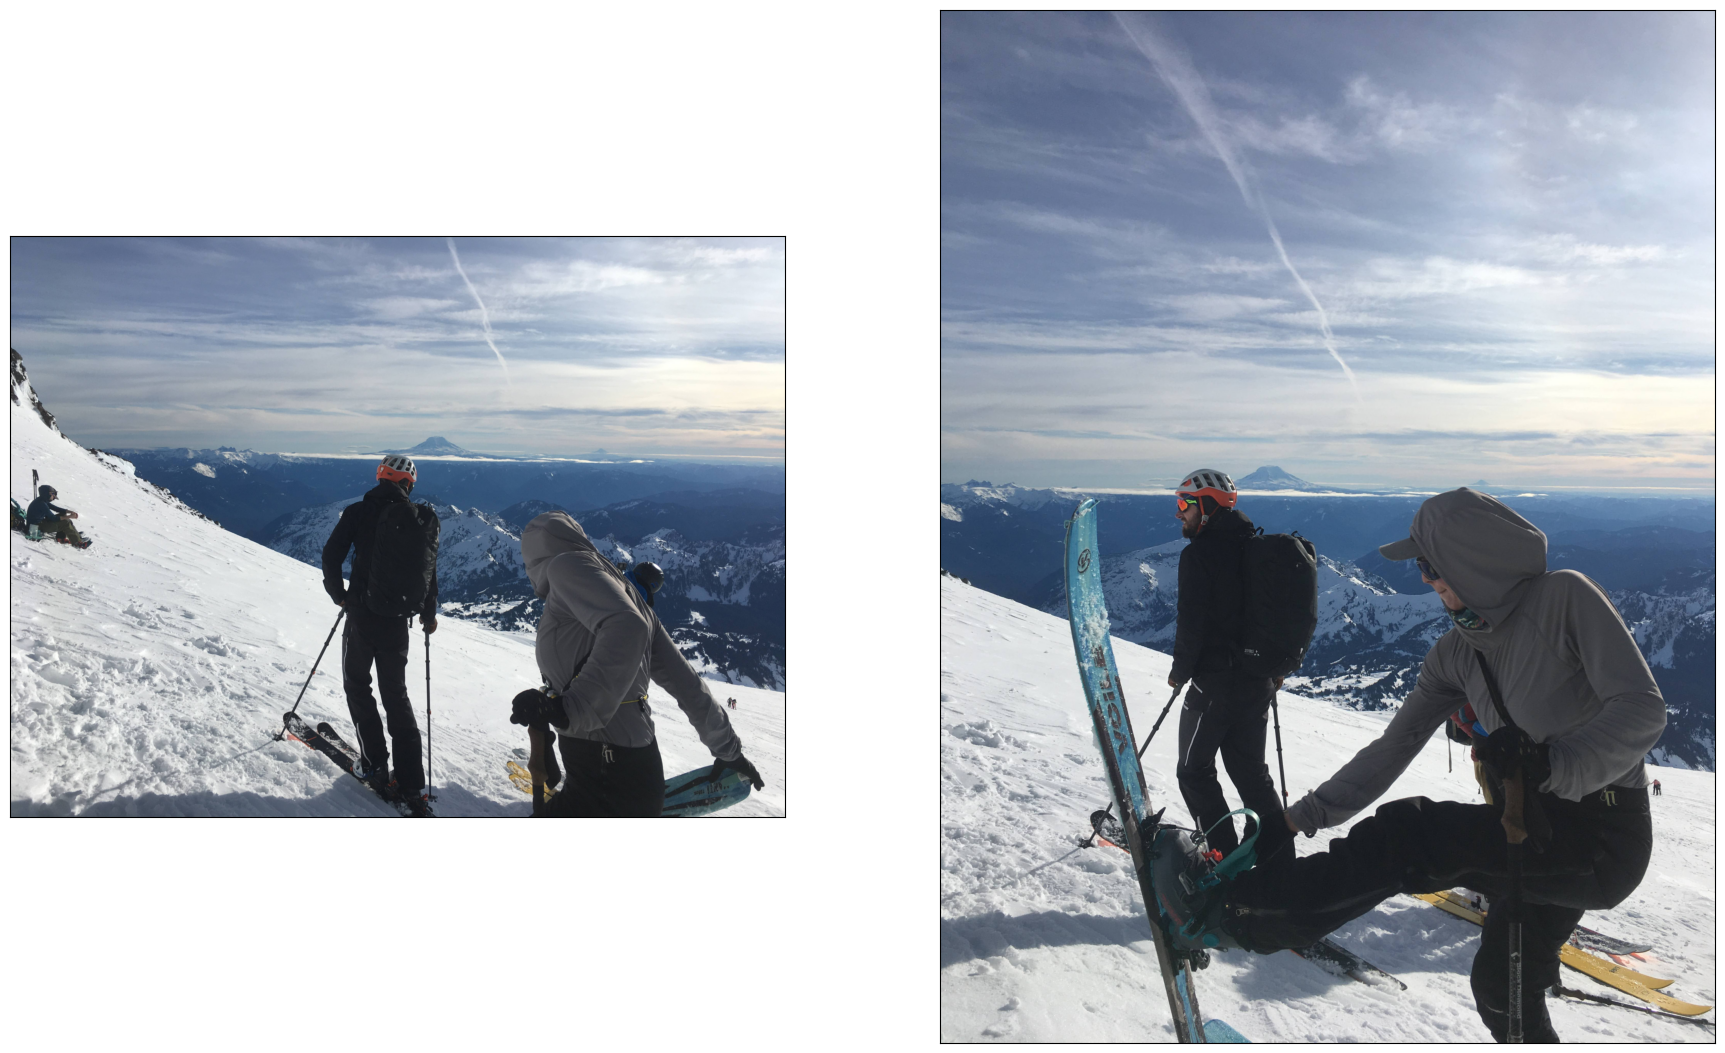

In [8]:
## visualise
cv_utility.show(imgs, figsize = (22,22))

## Load the maskrcnn model

In [9]:
maskrcnn = cv_models.get_maskrcnn(num_classes=-1, pretrained=True)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 176MB/s]


In [10]:
## Get the model predictions
device = "cuda" if torch.cuda.is_available() else "cpu"

preds = cv_utility.get_preds(imgs, maskrcnn, device)

## Visualise the images by overlaying the pred with the images

In [11]:
%matplotlib inline
style = {'description_width': 'initial'}

@interact
def vizualize_label_targets(score_cut = widgets.FloatSlider(style= style,value=.5,min=0,max=1,step=.001, description = "score_cut"),
                            boxes = widgets.Checkbox(style= style,value=False,description='boxes'),
                            masks = widgets.Checkbox(style= style,value=False,description='masks'),
                            labels = widgets.Checkbox(style= style,value=False,description='labels'),
                            box_width = widgets.IntSlider(style= style,value=5,min=1,max=50,step=1, description = "box_width"),
                            box_fill = widgets.Checkbox(style= style,value=False,description='box_fill'),
                            mask_threshold = widgets.FloatSlider(style= style,value=.5,min=0,max=1,step=.001, description = "mask_threshold"),
                            mask_alpha = widgets.FloatSlider(style= style,value=.4,min=0,max=1,step=.001, description = "mask_alpha"),
                            label_size = widgets.IntSlider(style= style,value=2,min=1,max=10,step=1, description = "label_size"),
                            label_width = widgets.IntSlider(style= style,value=2,min=1,max=10,step=1, description = "label_width"),
                            display_size = widgets.IntSlider(style= style, value=20,min=5,max=50,step=1),
                            save = widgets.Checkbox(style= style,value=False,description='save')
                            ):

    config = {"score_cut": score_cut,
            "boxes": boxes,
            "masks": masks,
            "labels": labels,
            "box_width": box_width,
            "box_fill" : box_fill,
            "mask_threshold": mask_threshold,
            "mask_alpha": mask_alpha,
            "label_size": label_size,
            "label_width": label_width}

    processed_imgs = cv_utility.maskrcnn_process_images(imgs, preds, coco_class_map, config)

    cv_utility.show(processed_imgs, figsize = (display_size,display_size))

    if save:

        base_path = "/content/drive/MyDrive/biotech/Retina_Lab"
        base_name = "mt_rainier_seg"

        cv_utility.save_imgs(processed_imgs, base_path, base_name)

interactive(children=(FloatSlider(value=0.5, description='score_cut', max=1.0, step=0.001, style=SliderStyle(d…